<a href="https://colab.research.google.com/github/femi-25/Bias-mitigation-in-sport-talent-evaluation/blob/main/Player_talent_prediction_with_GNNs_Florian_GBAGUIDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
file_path = "/content/drive/My Drive/players_21.csv"


In [3]:
import pandas as pd
df = pd.read_csv(file_path)


we are going to use a graph neural network and and our data structure must be graph so we need to transform our structured structure data into aa graph

In [4]:
import numpy as np


In [5]:
# Install necessary packages
!pip install torch
!pip install torch_geometric
!pip install fairlearn

# Standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch and PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MSELoss, Embedding, Linear, Dropout, Module
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GATv2Conv

# Scikit-learn utilities
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Fairlearn metrics
from fairlearn.metrics import MetricFrame, selection_rate, mean_prediction, demographic_parity_difference

# Graph visualization
import networkx as nx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Let's do an analysis of the dataset

In [6]:
df


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,...,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,...,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,...,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,67+3,62+3,62+3,62+3,67+3,62+3,49+3,49+3,49+3,62+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18939,256679,https://sofifa.com/player/256679/kevin-angulo/...,K. Angulo,Kevin Angulo,24,1996-04-13,176,73,Colombia,América de Cali,...,47+2,47+2,47+2,47+2,47+2,47+2,46+2,46+2,46+2,47+2
18940,257710,https://sofifa.com/player/257710/mengxuan-zhan...,Zhang Mengxuan,Mengxuan Zhang,21,1999-04-26,177,70,China PR,Chongqing Dangdai Lifan FC SWM Team,...,42+2,41+2,41+2,41+2,42+2,45+2,47+2,47+2,47+2,45+2
18941,250989,https://sofifa.com/player/250989/zhenghao-wang...,Wang Zhenghao,王政豪,20,2000-06-28,185,74,China PR,Tianjin TEDA FC,...,42+2,42+2,42+2,42+2,42+2,44+2,47+2,47+2,47+2,44+2
18942,257697,https://sofifa.com/player/257697/zitong-chen/2...,Chen Zitong,Zitong Chen,23,1997-02-20,186,80,China PR,Shijiazhuang Ever Bright F.C.,...,47+2,49+2,49+2,49+2,47+2,47+2,49+2,49+2,49+2,47+2


In [7]:
print(list(df.columns))


['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_ba

let's drop the useless columns and keep the importants columns

In [8]:
#dropping useless columns
drop_cols = [
    'sofifa_id', 'player_url', 'short_name', 'long_name', 'dob',
    'real_face', 'joined', 'contract_valid_until', 'player_url',
    'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw',
    'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm',
    'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'
]
df = df.drop(columns=drop_cols)


In [9]:
#keep remaining columns
print(list(df.columns))

['age', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentali

when we are predictind a player potential to be a talent some of the informations are not yet available

In [10]:
#removing the informations which may not be available during prediction
leakage_or_irrelevant_cols = [
    'value_eur', 'wage_eur',
    'club_name', 'league_name', 'league_rank',
    'team_position', 'team_jersey_number',
    'loaned_from', 'nation_position', 'nation_jersey_number',
    'release_clause_eur',
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
    'goalkeeping_positioning', 'goalkeeping_reflexes',
    'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_positioning', 'international_reputation', 'gk_speed',
]

df = df.drop(columns=leakage_or_irrelevant_cols)


In [11]:
print(list(df.columns))

['age', 'height_cm', 'weight_kg', 'nationality', 'overall', 'potential', 'player_positions', 'preferred_foot', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'player_tags', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']


lets seperate numerical features from categorical features

In [12]:
# Shape of dataset
print("Shape of dataset:", df.shape)

# First rows
print("\nFirst 5 rows:")
print(df.head())

# Data types
print("\nData types:")
print(df.dtypes)

# Summary stats for numerical columns
print("\nDescriptive statistics (numerical):")
print(df.describe())

# Summary stats for categorical columns
print("\nDescriptive statistics (categorical):")
print(df.describe(include=['object']))

# Count missing values
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False))

# Percentage of missing values
print("\nPercentage of missing values:")
missing_percentage = df.isnull().mean() * 100
print(missing_percentage.sort_values(ascending=False))

# Check for duplicated rows
print("\nNumber of duplicated rows:", df.duplicated().sum())


Shape of dataset: (18944, 49)

First 5 rows:
   age  height_cm  weight_kg nationality  overall  potential player_positions  \
0   33        170         72   Argentina       93         93       RW, ST, CF   
1   35        187         83    Portugal       92         92           ST, LW   
2   27        188         87    Slovenia       91         93               GK   
3   31        184         80      Poland       91         91               ST   
4   28        175         68      Brazil       91         91          LW, CAM   

  preferred_foot  weak_foot  skill_moves  ... power_long_shots  \
0           Left          4            4  ...               94   
1          Right          4            5  ...               93   
2          Right          3            1  ...               12   
3          Right          4            4  ...               85   
4          Right          5            5  ...               84   

  mentality_aggression mentality_interceptions  mentality_positioning  

Based on the statistical analysis we need ro get rid of the rows defending_marking , player_tags and player_traits and for the remainning columns with empty values replace the empty row by the median

In [13]:
drop_cols = ['defending_marking', 'player_tags', 'player_traits','body_type']
df = df.drop(columns=drop_cols)

In [14]:
# For all numerical columns with missing values
for col in df.columns:
    if df[col].isnull().sum() > 0 and df[col].dtype in ['int64', 'float64']:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_value}")

Filled missing values in 'pace' with median: 68.0
Filled missing values in 'shooting' with median: 54.0
Filled missing values in 'passing' with median: 58.0
Filled missing values in 'dribbling' with median: 64.0
Filled missing values in 'defending' with median: 56.0
Filled missing values in 'physic' with median: 66.0


/tmp/ipython-input-14-4050213763.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)


In [15]:
# Count missing values
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False))


Missing values per column:
age                           0
height_cm                     0
weight_kg                     0
nationality                   0
overall                       0
potential                     0
player_positions              0
preferred_foot                0
weak_foot                     0
skill_moves                   0
work_rate                     0
pace                          0
shooting                      0
passing                       0
dribbling                     0
defending                     0
physic                        0
attacking_crossing            0
attacking_finishing           0
attacking_heading_accuracy    0
attacking_short_passing       0
attacking_volleys             0
skill_dribbling               0
skill_curve                   0
skill_fk_accuracy             0
skill_long_passing            0
skill_ball_control            0
movement_acceleration         0
movement_sprint_speed         0
movement_agility              0
movement_rea

In [16]:
df.head(100)

,age,height_cm,weight_kg,nationality,overall,potential,player_positions,preferred_foot,weak_foot,skill_moves,...,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle
0,33,170,72,Argentina,93,93,"RW, ST, CF",Left,4,4,...,69,94,44,40,93,95,75,96,35,24
1,35,187,83,Portugal,92,92,"ST, LW",Right,4,5,...,78,93,63,29,95,82,84,95,32,24
2,27,188,87,Slovenia,91,93,GK,Right,3,1,...,78,12,34,19,11,65,11,68,12,18
3,31,184,80,Poland,91,91,ST,Right,4,4,...,86,85,81,49,94,79,88,88,42,19
4,28,175,68,Brazil,91,91,"LW, CAM",Right,5,5,...,50,84,51,36,87,90,92,93,30,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,29,180,80,Brazil,85,85,"LB, LM",Left,3,3,...,77,72,82,82,70,70,60,80,81,82
96,28,176,77,Spain,85,85,"CM, RM, LM",Right,4,3,...,75,80,79,80,82,85,59,84,80,70
97,29,163,59,Italy,85,85,"LW, CF",Right,4,4,...,34,84,34,26,81,85,74,83,24,22
98,29,179,67,Algeria,85,85,"RW, RM",Left,4,5,...,55,80,48,39,80,84,70,84,31,22


In [17]:
numerical_features = [
    'age', 'height_cm', 'weight_kg', 'overall',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
    'attacking_short_passing', 'attacking_volleys',
    'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
    'movement_reactions', 'movement_balance',
    'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
    'mentality_vision', 'mentality_penalties', 'mentality_composure',
     'defending_standing_tackle', 'defending_sliding_tackle','potential'
]

categorical_features = [
    'nationality', 'player_positions', 'preferred_foot',
    'weak_foot', 'skill_moves', 'work_rate'

]


In [18]:
df.shape

(18944, 45)

In [19]:
# Data types
print("\nData types:")
print(df.dtypes)


Data types:
age                             int64
height_cm                       int64
weight_kg                       int64
nationality                    object
overall                         int64
potential                       int64
player_positions               object
preferred_foot                 object
weak_foot                       int64
skill_moves                     int64
work_rate                      object
pace                          float64
shooting                      float64
passing                       float64
dribbling                     float64
defending                     float64
physic                        float64
attacking_crossing              int64
attacking_finishing             int64
attacking_heading_accuracy      int64
attacking_short_passing         int64
attacking_volleys               int64
skill_dribbling                 int64
skill_curve                     int64
skill_fk_accuracy               int64
skill_long_passing              int64

In [20]:
df.head()

,age,height_cm,weight_kg,nationality,overall,potential,player_positions,preferred_foot,weak_foot,skill_moves,...,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle
0,33,170,72,Argentina,93,93,"RW, ST, CF",Left,4,4,...,69,94,44,40,93,95,75,96,35,24
1,35,187,83,Portugal,92,92,"ST, LW",Right,4,5,...,78,93,63,29,95,82,84,95,32,24
2,27,188,87,Slovenia,91,93,GK,Right,3,1,...,78,12,34,19,11,65,11,68,12,18
3,31,184,80,Poland,91,91,ST,Right,4,4,...,86,85,81,49,94,79,88,88,42,19
4,28,175,68,Brazil,91,91,"LW, CAM",Right,5,5,...,50,84,51,36,87,90,92,93,30,29


In [21]:
#let's keep only one position for a player

# Extract main position (the first in the list)
df['main_position'] = df['player_positions'].apply(lambda x: x.split(',')[0].strip())


In [22]:
df = df.drop(columns=['player_positions'])

In [23]:
df[['att_work_rate', 'def_work_rate']] = df['work_rate'].str.split('/', expand=True)


In [24]:
df = df.drop(columns=['work_rate'])

In [25]:
df[['att_work_rate', 'def_work_rate', 'main_position']]

,att_work_rate,def_work_rate,main_position
0,Medium,Low,RW
1,High,Low,ST
2,Medium,Medium,GK
3,High,Medium,ST
4,High,Medium,LW
...,...,...,...
18939,Medium,Medium,CM
18940,Low,Low,CB
18941,Low,Medium,CB
18942,Low,Low,CM


In [26]:
print(df['nationality'].value_counts().head(50))


nationality
England                1685
Germany                1189
Spain                  1072
France                  984
Argentina               936
Brazil                  887
Japan                   489
Netherlands             432
Italy                   421
United States           378
Sweden                  372
China PR                364
Norway                  363
Mexico                  362
Poland                  360
Portugal                353
Uruguay                 349
Turkey                  344
Korea Republic          341
Colombia                338
Republic of Ireland     338
Romania                 324
Austria                 321
Saudi Arabia            317
Denmark                 300
Belgium                 298
Scotland                287
Ecuador                 252
Australia               241
Paraguay                235
Switzerland             211
Venezuela               198
Chile                   191
Peru                    161
Bolivia                 146
Croatia 

In [27]:
# 1. Get top 25 most common nationalities
top_25_nationalities = df['nationality'].value_counts().nlargest(25).index

# 2. Group the rest as "Other"
df['nationality_grouped'] = df['nationality'].apply(lambda x: x if x in top_25_nationalities else 'Other')


In [28]:
df.head()

,age,height_cm,weight_kg,nationality,overall,potential,preferred_foot,weak_foot,skill_moves,pace,...,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,main_position,att_work_rate,def_work_rate,nationality_grouped
0,33,170,72,Argentina,93,93,Left,4,4,85.0,...,93,95,75,96,35,24,RW,Medium,Low,Argentina
1,35,187,83,Portugal,92,92,Right,4,5,89.0,...,95,82,84,95,32,24,ST,High,Low,Portugal
2,27,188,87,Slovenia,91,93,Right,3,1,68.0,...,11,65,11,68,12,18,GK,Medium,Medium,Other
3,31,184,80,Poland,91,91,Right,4,4,78.0,...,94,79,88,88,42,19,ST,High,Medium,Poland
4,28,175,68,Brazil,91,91,Right,5,5,91.0,...,87,90,92,93,30,29,LW,High,Medium,Brazil


In [29]:
df = df.drop(columns=['nationality'])

In [30]:
# Assuming 'player_positions' contains positions as a string, e.g., 'GK' or 'CB, ST'
df = df[~df['main_position'].str.contains('GK')]


In [31]:
df = df.reset_index(drop=True)


In [32]:
# Shape of dataset
print("Shape of dataset:", df.shape)

# First rows
print("\nFirst 5 rows:")
print(df.head())

# Data types
print("\nData types:")
print(df.dtypes)


# Summary stats for categorical columns
print("\nDescriptive statistics (categorical):")
print(df.describe(include=['object']))




Shape of dataset: (16860, 46)

First 5 rows:
   age  height_cm  weight_kg  overall  potential preferred_foot  weak_foot  \
0   33        170         72       93         93           Left          4   
1   35        187         83       92         92          Right          4   
2   31        184         80       91         91          Right          4   
3   28        175         68       91         91          Right          5   
4   29        181         70       91         91          Right          5   

   skill_moves  pace  shooting  ...  mentality_positioning  mentality_vision  \
0            4  85.0      92.0  ...                     93                95   
1            5  89.0      93.0  ...                     95                82   
2            4  78.0      91.0  ...                     94                79   
3            5  91.0      85.0  ...                     87                90   
4            4  76.0      86.0  ...                     88                94   

   me

In [33]:


categorical_columns = ['preferred_foot', 'main_position', 'att_work_rate', 'def_work_rate', 'nationality_grouped']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le


In [34]:


correlation_features = numerical_features

# Assuming numerical_features list is correct up to this point for correlation calculation.

corr_df = df[correlation_features]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Show correlation with overall and potential
# Explicitly cast to Series and then sort
# Use .loc to explicitly select the 'overall' column as a Series
# This line should sort the values of the 'overall' correlation Series.
overall_corr = corr_matrix.loc[:, 'overall'].sort_values(ascending=False)
# Use .loc to explicitly select the 'potential' column as a Series
# This line should sort the values of the 'potential' correlation Series.
potential_corr = corr_matrix.loc[:, 'potential'].sort_values(ascending=False)


print("🔗 Correlation with OVERALL:\n", overall_corr)
print("\n🔗 Correlation with POTENTIAL:\n", potential_corr)

🔗 Correlation with OVERALL:
 overall                       1.000000
movement_reactions            0.869778
mentality_composure           0.805959
attacking_short_passing       0.761724
skill_ball_control            0.753313
passing                       0.711530
dribbling                     0.641104
potential                     0.627541
skill_long_passing            0.608151
skill_dribbling               0.570903
power_shot_power              0.569517
mentality_vision              0.548335
attacking_crossing            0.548269
physic                        0.530381
skill_curve                   0.528769
power_stamina                 0.510128
power_long_shots              0.505160
shooting                      0.488342
mentality_aggression          0.485754
attacking_heading_accuracy    0.472246
mentality_positioning         0.470516
age                           0.466604
skill_fk_accuracy             0.459858
attacking_volleys             0.451642
mentality_penalties           0.395

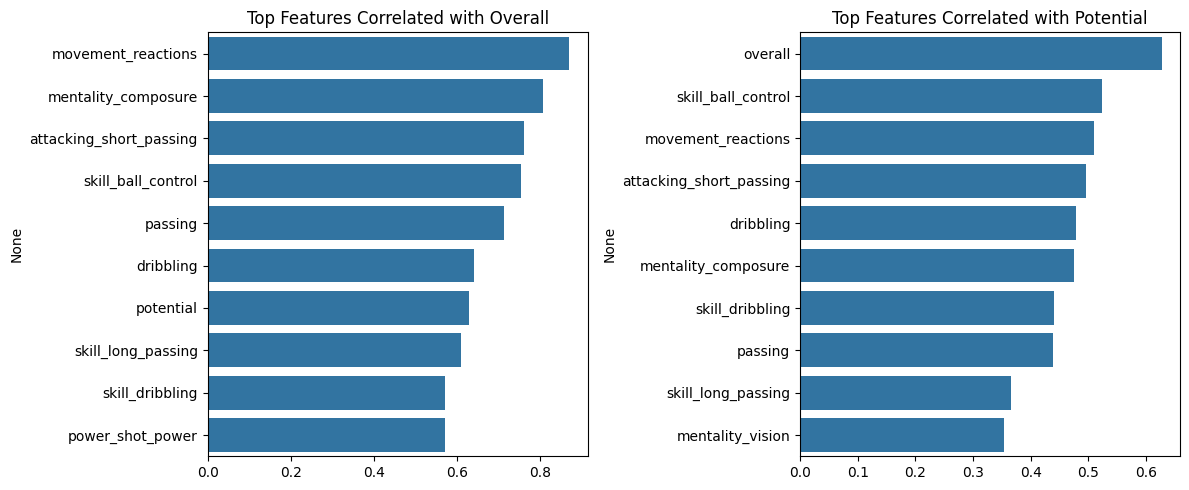

In [35]:
# Plot top 10 features most correlated with 'overall' and 'potential'
top_overall = overall_corr[1:11]  # exclude 'overall' itself
top_potential = potential_corr[1:11]  # exclude 'potential' itself

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(y=top_overall.index, x=top_overall.values)
plt.title("Top Features Correlated with Overall")

plt.subplot(1, 2, 2)
sns.barplot(y=top_potential.index, x=top_potential.values)
plt.title("Top Features Correlated with Potential")

plt.tight_layout()
plt.show()


from this analysis we can see that overall is much better target to predict than potential and can be our mesure to detect talent

In [36]:

# Remove 'potential' from the list if present
if 'overall' in numerical_features:
    numerical_features.remove('overall')

# Now create the tensor without the target
x_numeric = torch.tensor(df[numerical_features].values, dtype=torch.float)


In [37]:
# Encoded categorical features as separate tensors
preferred_foot_encoded = torch.tensor(df['preferred_foot_encoded'].values, dtype=torch.long)
main_position_encoded = torch.tensor(df['main_position_encoded'].values, dtype=torch.long)
att_work_rate_encoded = torch.tensor(df['att_work_rate_encoded'].values, dtype=torch.long)
def_work_rate_encoded = torch.tensor(df['def_work_rate_encoded'].values, dtype=torch.long)
nationality_encoded = torch.tensor(df['nationality_grouped_encoded'].values, dtype=torch.long)

In [38]:
# === Target Normalization ===
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df[['overall']].values).squeeze()
y = torch.tensor(y_scaled, dtype=torch.float)

In [39]:
numerical_features = [
    'age', 'height_cm', 'weight_kg',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
    'attacking_short_passing', 'attacking_volleys',
    'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
    'movement_reactions', 'movement_balance',
    'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
    'mentality_vision', 'mentality_penalties', 'mentality_composure',
     'defending_standing_tackle', 'defending_sliding_tackle','potential'
]

In [40]:

# ✅ Step 1: Use all available numeric features
all_features = df[numerical_features]


pca = PCA(n_components=10)
X_reduced = pca.fit_transform(all_features)


# ✅ Step 2: Normalize all features
scaler = StandardScaler()
X_all = scaler.fit_transform(X_reduced)

# ✅ Step 3: Compute k-Nearest Neighbors (e.g., k=5)
k = 5
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(X_all)
distances, indices = nbrs.kneighbors(X_all)

# ✅ Step 4: Build edge_index and edge_weight using similarity (inverse distance)
rows, cols, weights = [], [], []
for i, (dists, neighs) in enumerate(zip(distances, indices)):
    for dist, j in zip(dists[1:], neighs[1:]):  # skip self
        rows.append(i)
        cols.append(j)
        similarity = 1 / (dist + 1e-8)  # Avoid divide by zero
        weights.append(similarity)

# ✅ Step 5: Convert to PyTorch tensors
edge_index = torch.tensor([rows, cols], dtype=torch.long)
edge_weight = torch.tensor(weights, dtype=torch.float)

In [41]:
# === Edge Weight Clipping ===
mean_weight = edge_weight.mean()
std_weight = edge_weight.std()
edge_weight = torch.clamp(edge_weight, max=mean_weight + 3 * std_weight)

In [42]:
# === Train/Test Split ===


idx = np.arange(x_numeric.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)
train_mask = torch.zeros(x_numeric.shape[0], dtype=torch.bool)
test_mask = torch.zeros(x_numeric.shape[0], dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

In [43]:
# === PyG Data Object ===
data = Data(
    x=x_numeric,
    edge_index=edge_index,
    edge_attr=edge_weight,
    preferred_foot=preferred_foot_encoded,
    main_position=main_position_encoded,
    att_work_rate=att_work_rate_encoded,
    def_work_rate=def_work_rate_encoded,
    nationality=nationality_encoded,
    y=y,
    train_mask=train_mask,
    test_mask=test_mask
)

In [44]:
class GCNWithEmbeddings(Module):
    def __init__(self, num_node_features, num_classes,
                 num_foot_classes, num_position_classes,
                 num_att_wr_classes, num_def_wr_classes,
                 num_nationality_classes,
                 hidden_channels=64, dropout_rate=0.5):
        super(GCNWithEmbeddings, self).__init__()

        # Embedding layers for categorical features
        self.emb_foot = Embedding(num_foot_classes, 4)
        self.emb_position = Embedding(num_position_classes, 8)
        self.emb_att_wr = Embedding(num_att_wr_classes, 4)
        self.emb_def_wr = Embedding(num_def_wr_classes, 4)
        self.emb_nationality = Embedding(num_nationality_classes, 8)

        # Combined input size
        total_input_dim = num_node_features + 4 + 8 + 4 + 4 + 8

        self.conv1 = GCNConv(total_input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)
        self.dropout = Dropout(dropout_rate)

    def forward(self, data):
        x = data.x

        # Embed categorical features and concatenate
        foot_emb = self.emb_foot(data.preferred_foot)
        pos_emb = self.emb_position(data.main_position)
        att_wr_emb = self.emb_att_wr(data.att_work_rate)
        def_wr_emb = self.emb_def_wr(data.def_work_rate)
        nat_emb = self.emb_nationality(data.nationality)

        x = torch.cat([x, foot_emb, pos_emb, att_wr_emb, def_wr_emb, nat_emb], dim=1)

        x = self.conv1(x, data.edge_index, edge_weight=data.edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, data.edge_index, edge_weight=data.edge_weight)
        x = self.dropout(x)
        x = self.lin(x)
        return x.squeeze()


In [45]:
# 4) Instantiate, loss & optimizer
model =  GCNWithEmbeddings(
    # Changed num_num_feats to num_node_features to match the class constructor
    num_node_features = data.x.size(1),
    num_classes = 1, # Assuming you are predicting a single value (overall)
    num_foot_classes         = int(data.preferred_foot.max()+1),
    num_position_classes     = int(data.main_position.max()+1),
    num_att_wr_classes       = int(data.att_work_rate.max()+1),
    num_def_wr_classes       = int(data.def_work_rate.max()+1),
    num_nationality_classes  = int(data.nationality.max()+1),
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)

Epoch 000  Loss: 7378.8540  MAE: 1124.2576  RMSE: 1160.3365
Group-wise MAE (partial):
group
Argentina              1151.543055
Austria                1131.997470
Brazil                 1218.240509
China PR               1036.519572
Colombia               1052.466198
Denmark                1133.442818
England                1095.763794
France                 1138.242788
Germany                1118.133149
Italy                  1202.177365
Japan                  1074.526869
Korea Republic         1081.136270
Mexico                 1093.770869
Netherlands            1139.583157
Norway                 1123.483831
Other                  1128.880962
Poland                 1054.228088
Portugal               1148.344730
Republic of Ireland    1058.813042
Romania                1072.983362
Saudi Arabia           1000.947942
Spain                  1214.152145
Sweden                 1102.992765
Turkey                 1126.485344
United States          1101.059257
Uruguay                1077.81307

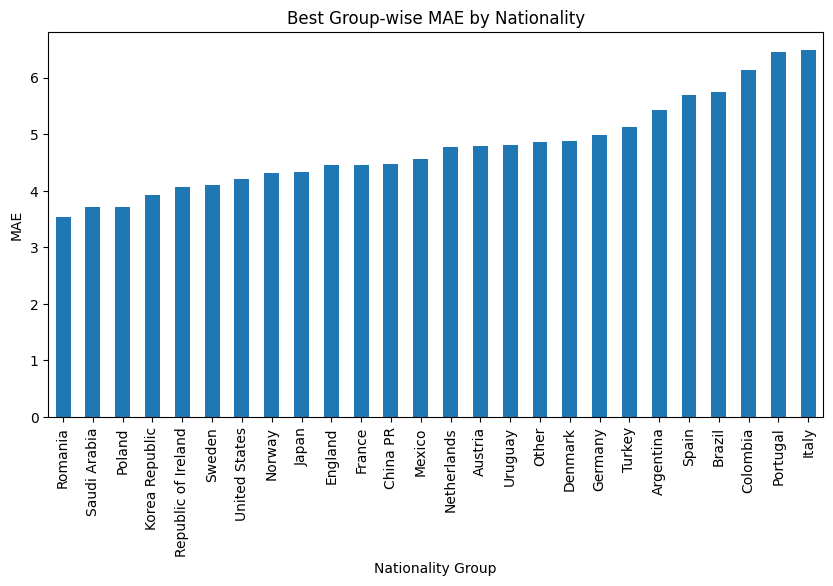

In [47]:
best_mae = float('inf')
best_epoch = -1
best_state_dict = None
best_group_mae = None
epochs = 200

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out_eval = model(data).squeeze()
        pred = out_eval[data.test_mask].cpu().numpy()
        true = data.y[data.test_mask].cpu().numpy()
        pred_rescaled = scaler_y.inverse_transform(pred.reshape(-1, 1)).flatten()
        true_rescaled = scaler_y.inverse_transform(true.reshape(-1, 1)).flatten()
        mae = mean_absolute_error(true_rescaled, pred_rescaled)
        rmse = np.sqrt(mean_squared_error(true_rescaled, pred_rescaled))

        group_labels = data.nationality[data.test_mask].cpu().numpy()
        group_names = label_encoders['nationality_grouped'].inverse_transform(group_labels)
        df_eval = pd.DataFrame({'true': true_rescaled, 'pred': pred_rescaled, 'group': group_names})

        fairness_frame = MetricFrame(
            metrics={"mae": mean_absolute_error},
            y_true=df_eval["true"],
            y_pred=df_eval["pred"],
            sensitive_features=df_eval["group"]
        )
        group_mae_series = fairness_frame.by_group["mae"]

        # Track best model
        if mae < best_mae:
            best_mae = mae
            best_rmse = rmse
            best_epoch = epoch
            best_state_dict = model.state_dict()
            best_group_mae = group_mae_series.copy()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}  MAE: {mae:.4f}  RMSE: {rmse:.4f}")
        print("Group-wise MAE (partial):")
        print(group_mae_series)

# === Load Best Model After Training ===
model.load_state_dict(best_state_dict)

print(f"\n✅ Best model found at Epoch {best_epoch}  MAE: {best_mae:.4f}  RMSE: {best_rmse:.4f}")
print("\n📊 Final Group-wise MAE by Nationality (Best Epoch):")
print(best_group_mae.sort_values())

# Optional: Plot
best_group_mae.sort_values().plot(kind='bar', figsize=(10,5), title='Best Group-wise MAE by Nationality')
plt.ylabel("MAE")
plt.xlabel("Nationality Group")
plt.show()

In [48]:
df_eval['residual'] = df_eval['true'] - df_eval['pred']


/tmp/ipython-input-49-2384412426.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 33.898014  31.898006  30.898006 ... -12.101994 -12.101994 -12.101994]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_full.loc[data.test_mask.cpu().numpy(), 'residual'] = df_eval['residual'].values
/tmp/ipython-input-49-2384412426.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y=feat, data=df_full[df_full['group'].notna()], palette='coolwarm') # Filter for non-null group values


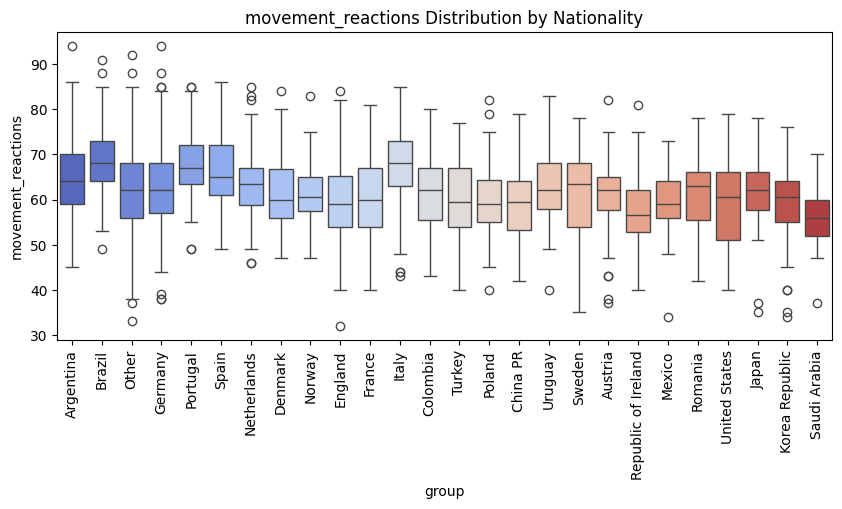

/tmp/ipython-input-49-2384412426.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values


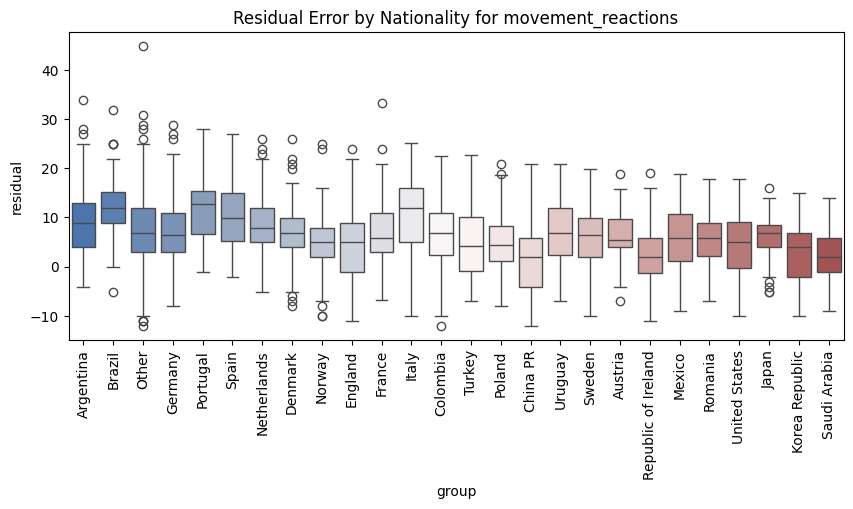

/tmp/ipython-input-49-2384412426.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y=feat, data=df_full[df_full['group'].notna()], palette='coolwarm') # Filter for non-null group values


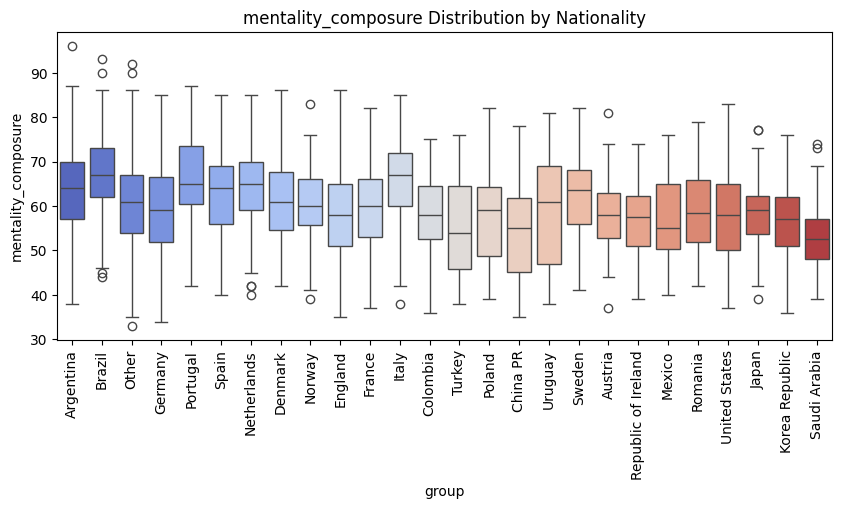

/tmp/ipython-input-49-2384412426.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values


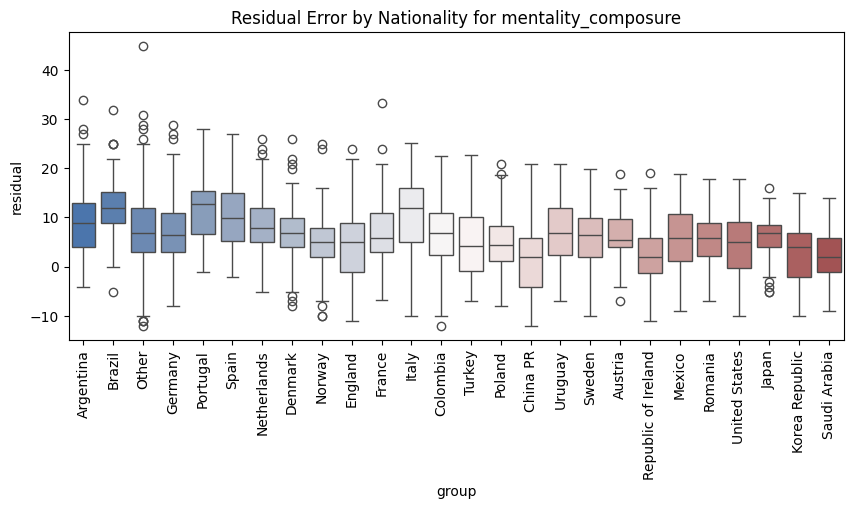

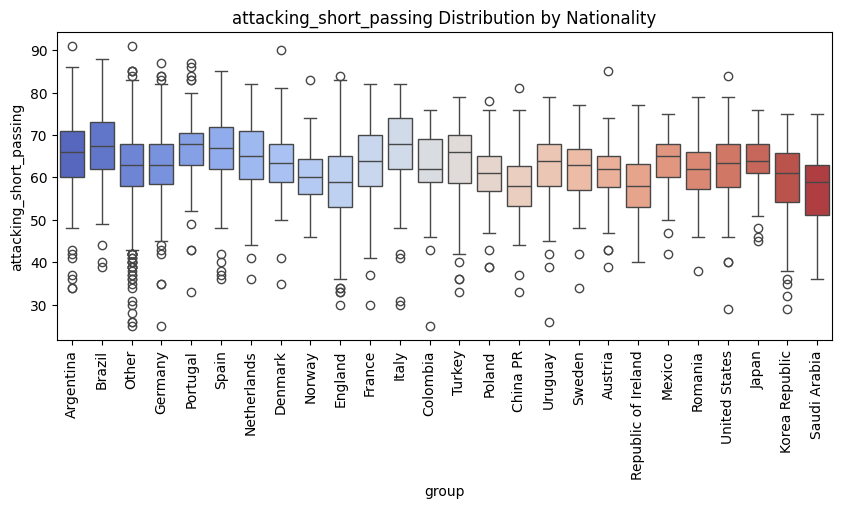

/tmp/ipython-input-49-2384412426.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values


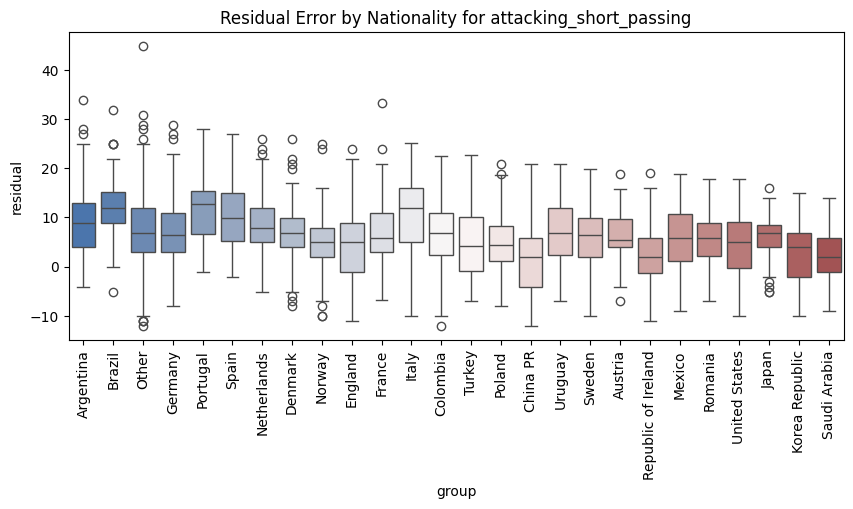

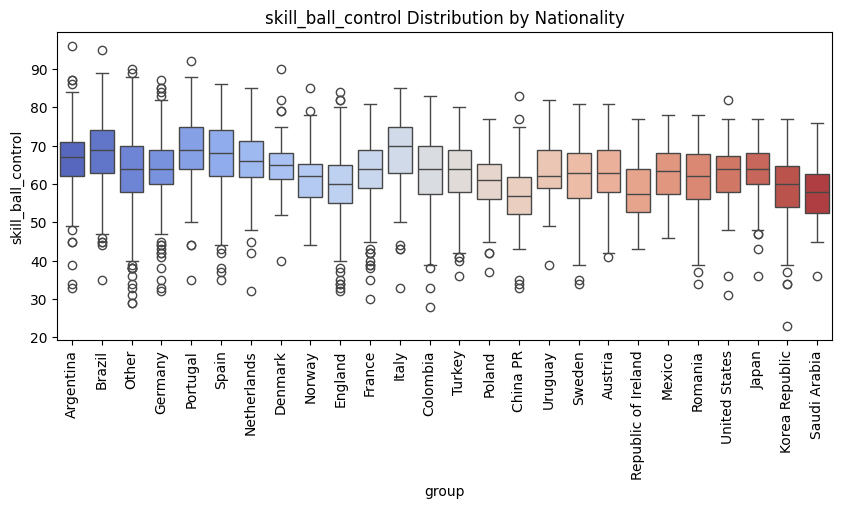

/tmp/ipython-input-49-2384412426.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values


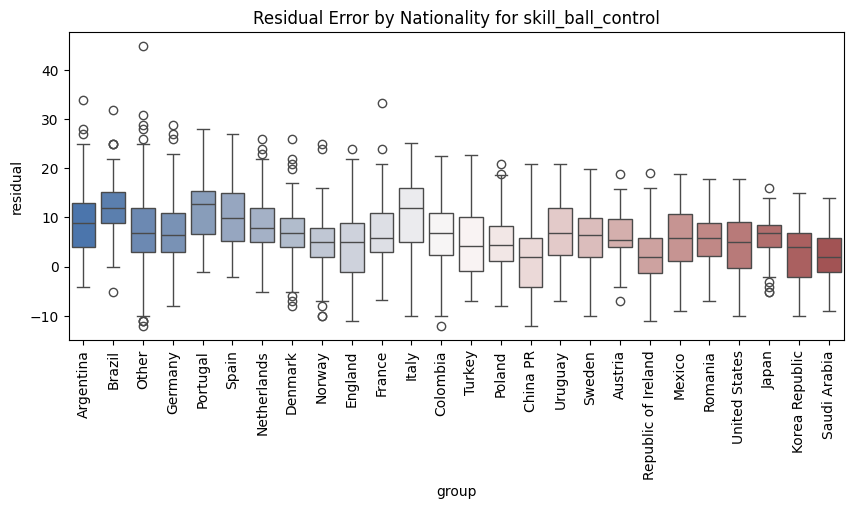

/tmp/ipython-input-49-2384412426.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y=feat, data=df_full[df_full['group'].notna()], palette='coolwarm') # Filter for non-null group values


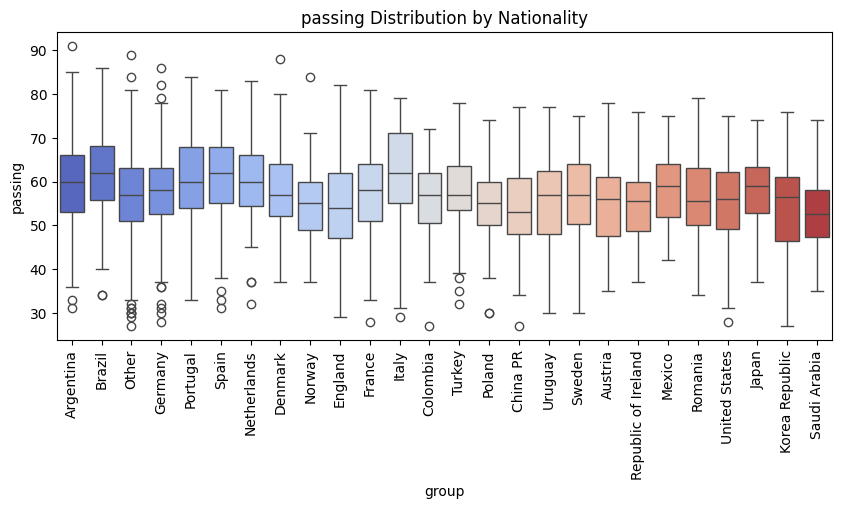

/tmp/ipython-input-49-2384412426.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values


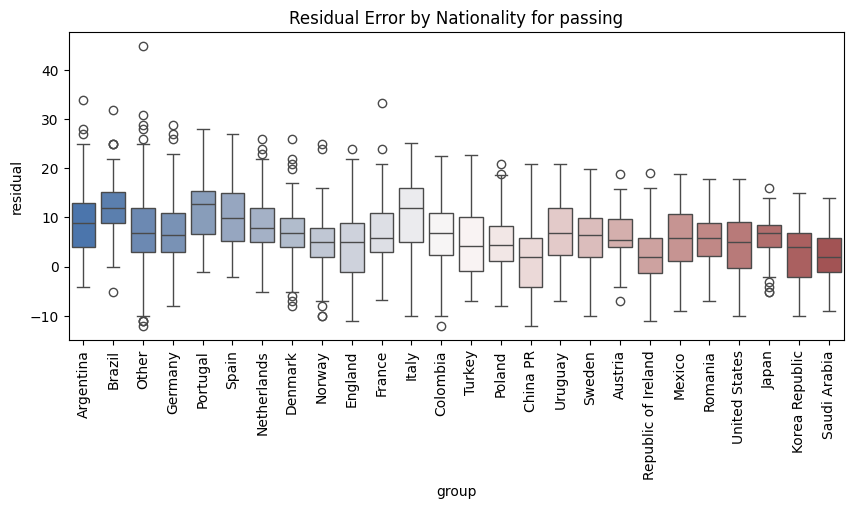

/tmp/ipython-input-49-2384412426.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y=feat, data=df_full[df_full['group'].notna()], palette='coolwarm') # Filter for non-null group values


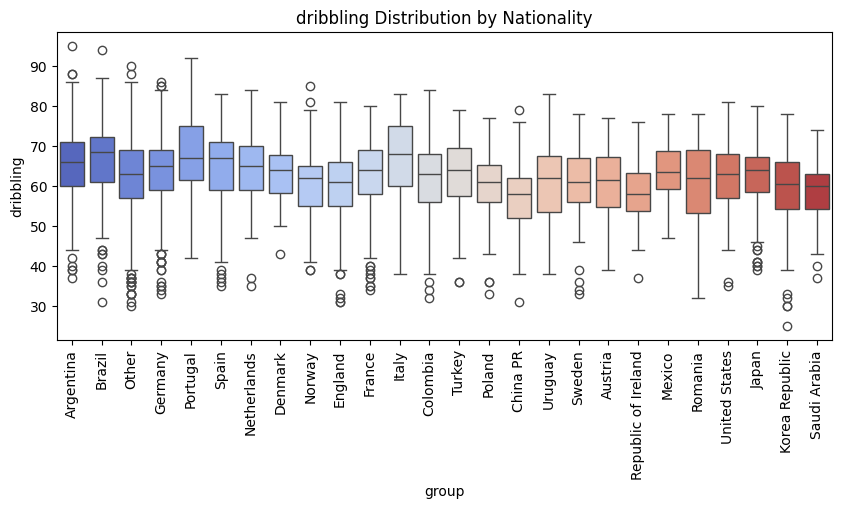

/tmp/ipython-input-49-2384412426.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values


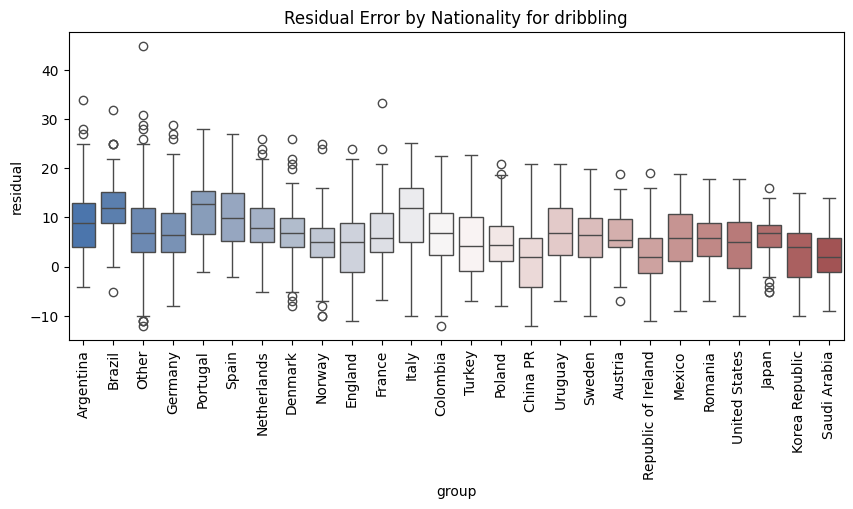

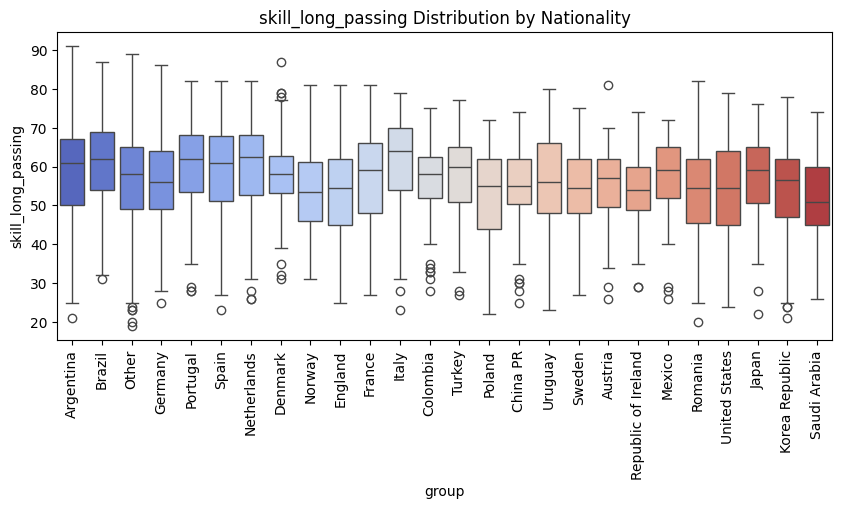

/tmp/ipython-input-49-2384412426.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values


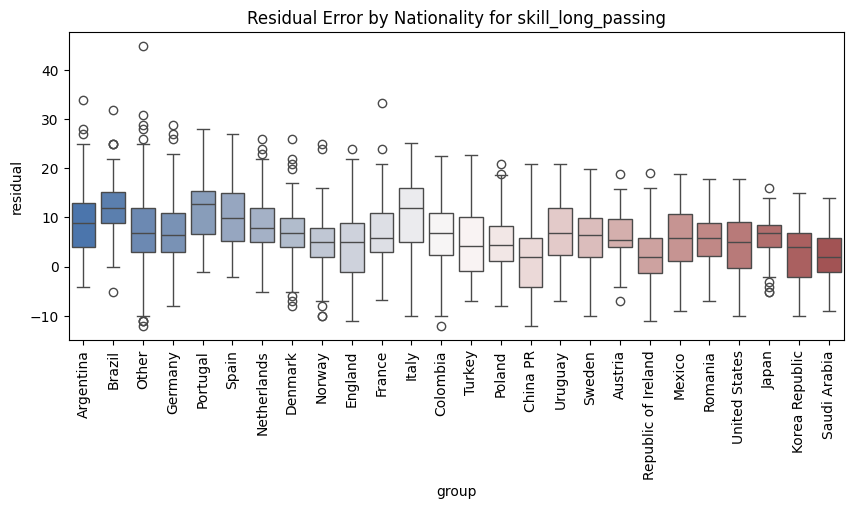

/tmp/ipython-input-49-2384412426.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y=feat, data=df_full[df_full['group'].notna()], palette='coolwarm') # Filter for non-null group values


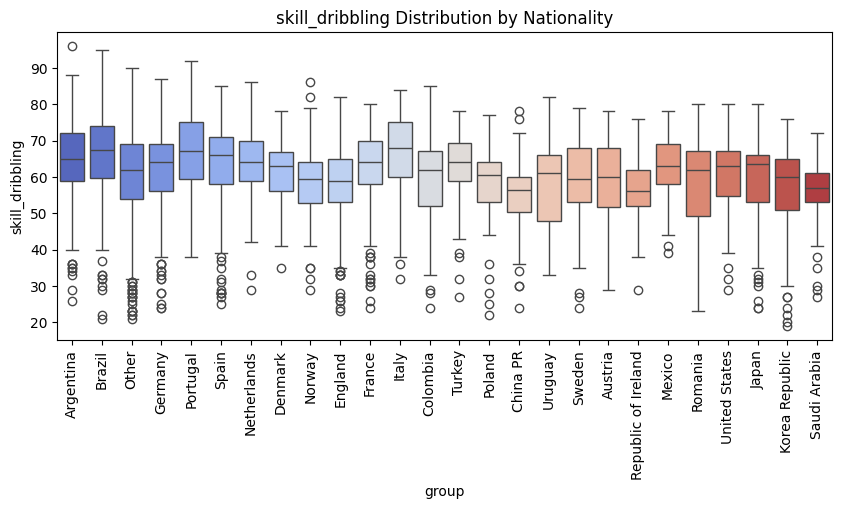

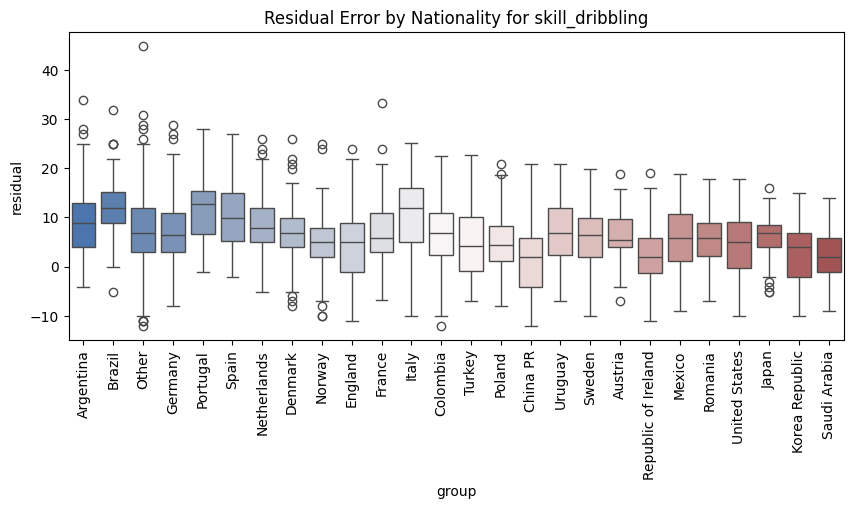

/tmp/ipython-input-49-2384412426.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y=feat, data=df_full[df_full['group'].notna()], palette='coolwarm') # Filter for non-null group values


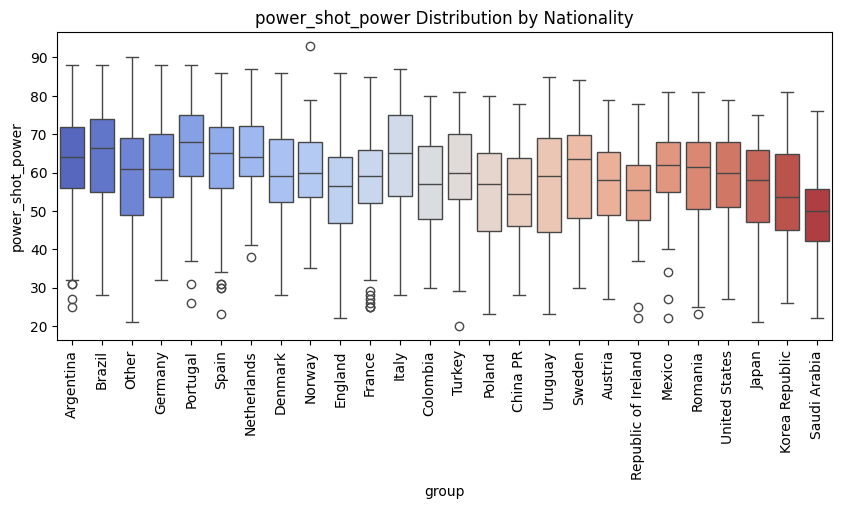

/tmp/ipython-input-49-2384412426.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values


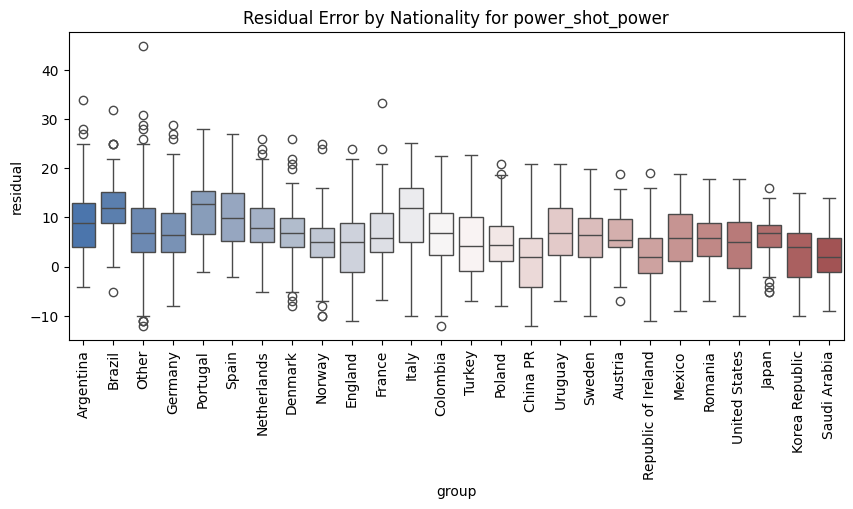

/tmp/ipython-input-49-2384412426.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y=feat, data=df_full[df_full['group'].notna()], palette='coolwarm') # Filter for non-null group values


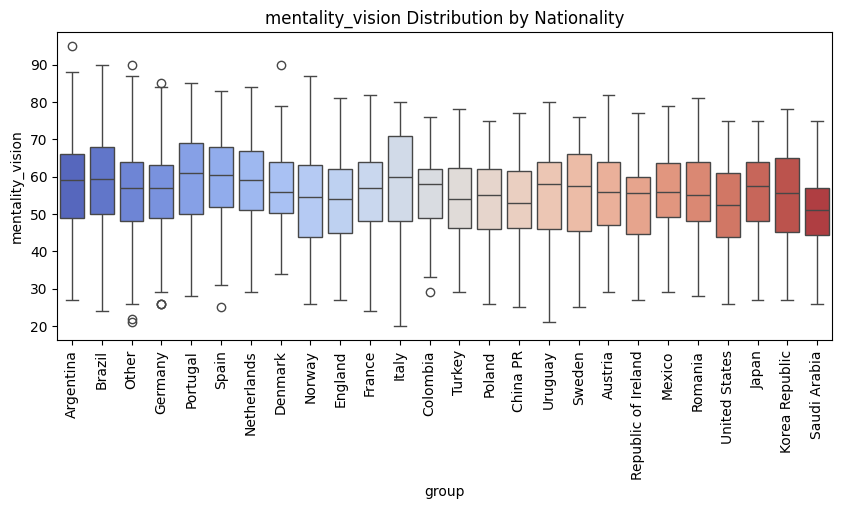

/tmp/ipython-input-49-2384412426.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values


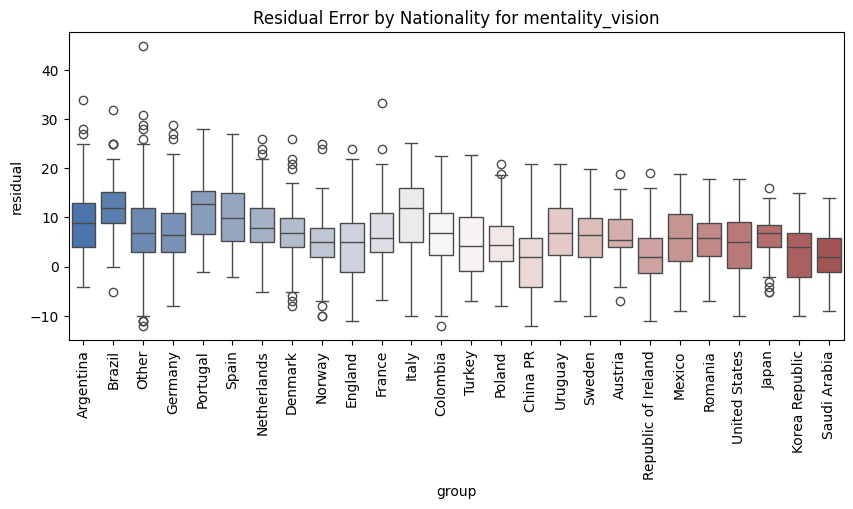

In [49]:


# Join back with full features
df_full = df.copy()
df_full['residual'] = 0
df_full.loc[data.test_mask.cpu().numpy(), 'residual'] = df_eval['residual'].values
# Assign group labels only to the test set indices
df_full.loc[data.test_mask.cpu().numpy(), 'group'] = df_eval['group'].values

# Plot feature-wise error
key_features = [
    'movement_reactions',
    'mentality_composure',
    'attacking_short_passing',
    'skill_ball_control',
    'passing',
    'dribbling',
    'skill_long_passing',
    'skill_dribbling',
    'power_shot_power',
    'mentality_vision'
]

for feat in key_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='group', y=feat, data=df_full[df_full['group'].notna()], palette='coolwarm') # Filter for non-null group values
    plt.title(f'{feat} Distribution by Nationality')
    plt.xticks(rotation=90)
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.boxplot(x='group', y='residual', data=df_full[df_full['group'].notna()], palette='vlag') # Filter for non-null group values
    plt.title(f'Residual Error by Nationality for {feat}')
    plt.xticks(rotation=90)
    plt.show()

In [50]:
# Check how features relate to residual error
feature_cols = numerical_features
correlations = df_full[feature_cols + ['residual']].corr()['residual'].drop('residual')
print("🔍 Feature-Error Correlations:\n", correlations.sort_values(ascending=False))


🔍 Feature-Error Correlations:
 movement_reactions            0.286271
mentality_composure           0.262650
attacking_short_passing       0.242212
skill_ball_control            0.238842
passing                       0.224579
potential                     0.212294
skill_long_passing            0.198066
dribbling                     0.197996
physic                        0.185365
power_shot_power              0.178170
skill_dribbling               0.174121
attacking_crossing            0.172478
mentality_vision              0.169427
power_stamina                 0.169171
mentality_aggression          0.164814
attacking_heading_accuracy    0.162710
skill_curve                   0.160959
power_long_shots              0.155385
age                           0.154872
shooting                      0.147288
skill_fk_accuracy             0.143791
mentality_positioning         0.143662
attacking_volleys             0.137618
defending                     0.130649
power_strength                0.1